# Projet 4 :

# Anticipez les besoins en consommation de bâtiments

# Notebook de la partie modélisation et prédiction de la consommation d'énergie

# Salma CHAFAI

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

**Résumé du projet**

On cherche à atteindre l'objectif de ville neutre en émissions de carbone en 2050 pour la ville de Seattle. Notre équipe va s'intéresser de près aux émissions des bâtiments non destinés à l'habitation.
Les relevés obtenus en 2016 ont été efféctués par des agents et ils sont coûteux à obtenir. L'objectif est de prédire les émissions de C02 et la consommation totale d'énergie de bâtiments pour lesquels elles n'ont pas encore été mesurées.

## A) Importation des bibliothèques essentiels

### 1- Les bibliothèques usuelles

In [1]:
# ça nous permet d'importer numpy avec son nom np et matplotlib.pyplot as plt
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
import missingno as msn

In [3]:
import plotly.graph_objects as go
import plotly as plo
import plotly.express as px

In [4]:
from time import time

### 2- Les bibliothèques pour le preprocessing et les modèles du machine learning

In [5]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer, QuantileTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
from category_encoders import TargetEncoder

In [6]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold

In [7]:
# pickle est un package qu'on utilise pour mettre dedans ou pour générer notre modèle pour le déployer dans une application
import pickle

In [8]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import kernel_ridge
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [9]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score

### 4- Les bibliothèques pour les features engineering

In [10]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [11]:
from sklearn.impute import SimpleImputer

In [12]:
import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do
import shap #SHAP package
import time #some of the routines take a while so we monitor the time
import os #needed to use Environment Variables in Domino

## B) Le jeu de données

In [13]:
dataElec = pd.read_csv("C:/Users/salma/OneDrive/Bureau/Formation en alternance 2021_2023/Formation OpenClassRooms/Projets/Projet 4/projet_nouvelle_version/Data/dataElec_clean_f.csv", sep=',')
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
dataElec.head(10)

,BuildingType,PrimaryPropertyType,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,ENERGYSTARScore
0,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,No_SecondUse,No_ThirdUse,47.61220,-122.33799,1927,1.0,12,88434,0,88434,88434.0,0.0,0.0,84.300003,189.000000,7226362.5,2003882.00,3946027.0,1276453.0,249.98,60.0
1,NonResidential,Hotel,DOWNTOWN,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,83880.0,15064.0,4622.0,97.900002,179.399994,8387933.0,0.00,3242851.0,5145082.0,295.86,61.0
2,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,No_SecondUse,No_ThirdUse,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,756493.0,0.0,0.0,97.699997,244.100006,72587024.0,21566554.00,49526664.0,1493800.0,2089.28,43.0
3,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,No_SecondUse,No_ThirdUse,47.61412,-122.33664,1926,1.0,10,61320,0,61320,61320.0,0.0,0.0,113.300003,224.000000,6794584.0,2214446.25,2768924.0,1811213.0,286.43,56.0
4,NonResidential,Hotel,DOWNTOWN,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,123445.0,68009.0,0.0,118.699997,215.600006,14172606.0,0.00,5368607.0,8803998.0,505.01,75.0
5,Nonresidential COS,Other,DOWNTOWN,Police Station,Police Station,No_SecondUse,No_ThirdUse,47.61623,-122.33657,1999,1.0,2,97288,37198,60090,88830.0,0.0,0.0,141.600006,320.500000,12086616.0,0.00,7371434.0,4715182.0,301.81,NaN
6,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,No_SecondUse,No_ThirdUse,47.61390,-122.33283,1926,1.0,11,83008,0,83008,81352.0,0.0,0.0,74.500000,154.699997,5758795.0,0.00,2811215.0,2947580.0,176.14,27.0
7,NonResidential,Other,DOWNTOWN,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,No_SecondUse,No_ThirdUse,47.61327,-122.33136,1926,1.0,8,102761,0,102761,102761.0,0.0,0.0,68.800003,152.300003,6298131.5,2276286.50,3636655.0,385189.0,221.51,NaN
8,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,No_SecondUse,No_ThirdUse,47.60294,-122.33263,1904,1.0,15,163984,0,163984,163984.0,0.0,0.0,86.599998,187.199997,13723820.0,0.00,7297919.0,6425900.0,392.16,43.0
9,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,No_SecondUse,No_ThirdUse,47.60695,-122.33414,1969,1.0,11,153163,19279,133884,133884.0,0.0,0.0,124.300003,233.000000,16016644.0,5237165.50,6187627.0,4591850.0,691.26,30.0


In [14]:
#Taille du jeu de données
dataElec.shape

(1513, 26)

<AxesSubplot:>

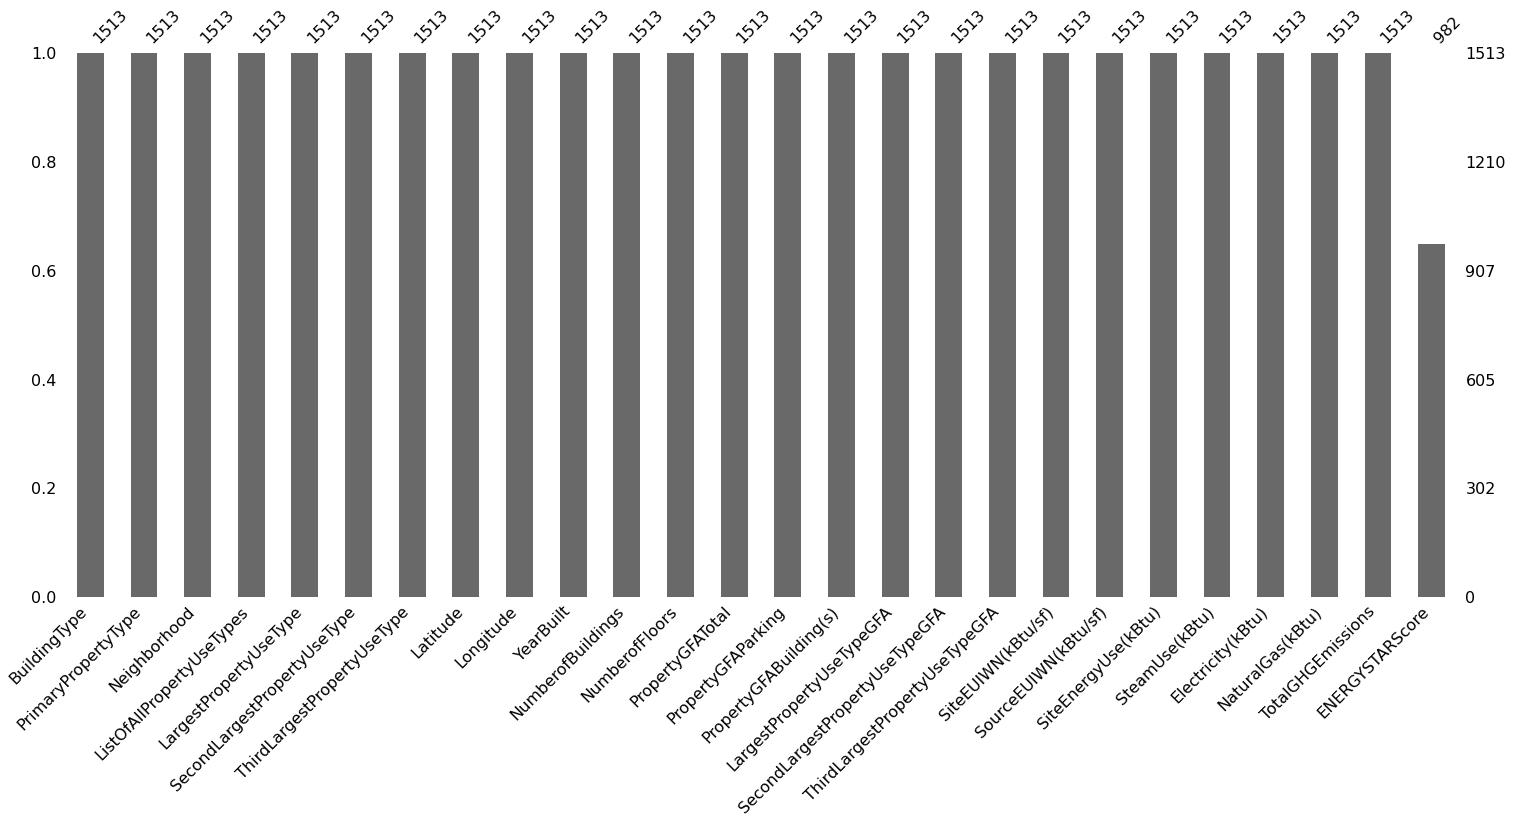

In [15]:
#On revérifie les valeurs nulls
msn.bar(dataElec)

## C) Pré-traitement des données (Pre-processing)

**Corrélation**

In [16]:
def cor(data) :
    mask_cor = np.triu(np.ones_like(data.corr(method='pearson'))) 
    plt.figure(figsize=(20,10)) 
    sns.heatmap(data.corr(), mask=mask_cor, annot=True)
    plt.show()

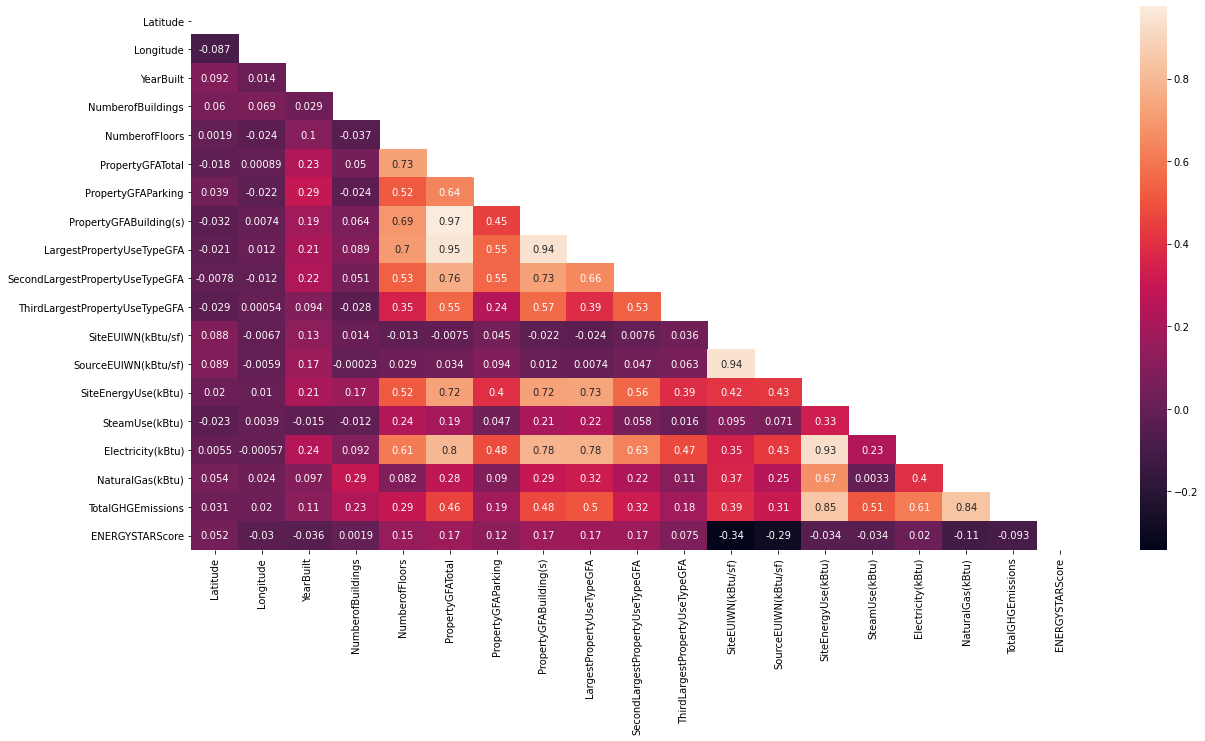

In [17]:
cor(dataElec)

### 1- Preprocessing et split

#### (a) On sépare notre jeu de données en X (features) et en y (variable cible :target)

In [18]:
def separate(data, target, col):
    X = data[col]
    y = data[target]
    return X,y

#### (b) Encodage, standardisation  et split 

In [19]:
def preprocessing_split(x,y, size,strat):
    
    numerical = list(x.select_dtypes('number').columns)
    categorical = list(x.select_dtypes('object').columns)
    
    cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    
    
    # Define numerical pipeline
    num_pipe = Pipeline([
        ('scaler', MinMaxScaler())
    ])

    # Fit column transformer to training data
    preprocessor = ColumnTransformer([
        ('cat', cat_pipe, categorical),
        ('num', num_pipe, numerical)
    ])
    
    x_train, x_test,y_train,y_test = train_test_split(x,y,test_size=size, stratify=strat, random_state=0)
    
    #On entraîne notre preprocessor
    preprocessor.fit(x_train)

    # Prepare column names
    cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical)
    columns = np.append(cat_columns, numerical)

    # Transformation de X_train
    x_train_transf = pd.DataFrame(preprocessor.transform(x_train), columns=columns)

    # Transformation de X_test
    x_test_transf = pd.DataFrame(preprocessor.transform(x_test), columns=columns)
    
    return x_train_transf, x_test_transf, y_train, y_test

### 3- Modélisation et premier modèle

In [20]:
def eval_model(model, x_train, x_test, y_train, y_test, params):

    grid_model = GridSearchCV(estimator=model,
                            param_grid=params,
                              scoring = 'r2')
    
    

    
    grid_model.fit(x_train, y_train)
    best_params = grid_model.best_params_
    model_f = grid_model.best_estimator_
    model_f.fit(x_train, y_train)
    
    y_pred = model_f.predict(x_test)
    y_pred_tr = model_f.predict(x_train)
    
    r2_train = r2_score(y_train, y_pred_tr)
    r2_test = r2_score(y_test, y_pred)
    
    mae_train = mean_absolute_error(y_train, y_pred_tr)
    mae_test = mean_absolute_error(y_test, y_pred)
    
    mse_train = mean_squared_error(y_train, y_pred_tr)
    mse_test = mean_squared_error(y_test, y_pred)
    
    rmse_train = sqrt(mse_train)
    rmse_test = sqrt(mse_test)
    
    cross_val = cross_val_score(model_f, x_train, y_train, cv=5)
    
    print('R2 score pour le train est :', r2_train)
    print('R2 score pour le test est :', r2_test)
    print('Mean squared erreur pour le train est :', mse_train)
    print('Mean squared erreur pour le test est :', mse_test)
    print('Mean absolute erreur pour le train est :', mae_train)
    print('Mean absolute erreur pour le test est :', mae_test)
    print('Root Mean squared erreur pour le train est :', rmse_train)
    print('Root Mean squared erreur pour le test est :', rmse_test)
    
    
    print("Validation score mean:", cross_val.mean())
    print("Validation score std:", cross_val.std())
    return best_params, y_test, y_pred, r2_train, r2_test, mse_train, mse_test, rmse_train, rmse_test, mae_train, mae_test
    
    

In [21]:
def plot_result(y_test, y_pred):
    plt.figure(figsize=(10,7))
    plt.scatter(y_test, y_pred, c='crimson')

    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()

**Application à la régression linéaire**

In [22]:
# On choisit les colonnes qu'on va garder
selected_col = ['BuildingType','Neighborhood','LargestPropertyUseType','LargestPropertyUseTypeGFA','YearBuilt',
                'NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)']

target = 'TotalGHGEmissions'
X,y = separate(data=dataElec, target=target, col=selected_col)

In [23]:
reg = LinearRegression()
params_reg = {'fit_intercept': [True, False]}


X_train, X_test,y_train,y_test = preprocessing_split(X,y, 0.2, strat=X['BuildingType'])
best_params, y_test_reg, y_pred_reg, r2_train_reg, r2_test_reg, mse_train, mse_test, rmse_train, rmse_test, mae_train_reg, mae_test_reg = eval_model(reg, X_train,X_test,y_train,y_test, params_reg)


R2 score pour le train est : 0.5290835057400316
R2 score pour le test est : 0.5031448083129963
Mean squared erreur pour le train est : 34908.0861055556
Mean squared erreur pour le test est : 77055.29025093536
Mean absolute erreur pour le train est : 97.9269717398478
Mean absolute erreur pour le test est : 109.72892612218071
Root Mean squared erreur pour le train est : 186.83705763460202
Root Mean squared erreur pour le test est : 277.58834674916625
Validation score mean: -1.0256423266750843e+22
Validation score std: 1.4380715420644754e+22


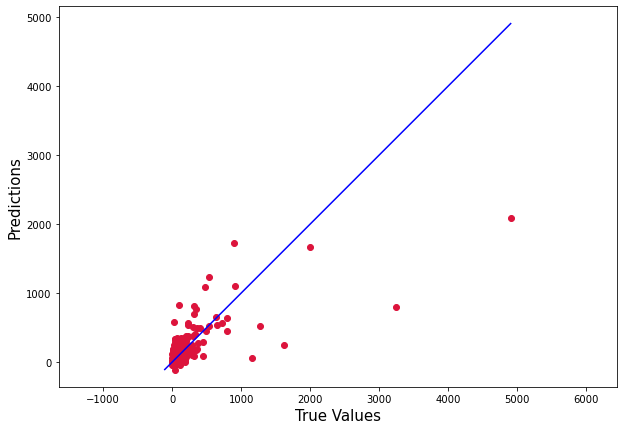

In [24]:
plot_result(y_test_reg, y_pred_reg)

## E) Feature Engineering

In [25]:
dataElec['LargestPropertyUseType'].value_counts()

Office                                                  484
Non-Refrigerated Warehouse                              197
Retail Store                                             91
Other                                                    90
Hotel                                                    75
Worship Facility                                         68
Distribution Center                                      54
K-12 School                                              46
Medical Office                                           41
Supermarket/Grocery Store                                40
Other - Recreation                                       31
Parking                                                  29
Self-Storage Facility                                    27
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
College/University                      

In [26]:
# On crée une fonction qui regroupe les catégories les moins présentes dans une les variables de type d'utilisation
#et renvoie un dictionnaire

def regroup_cat(data, col, seuil):
    dict_val = {}
    df_occ = pd.DataFrame(data[col].value_counts()).reset_index()
    df_occ.columns = ['Categorie', 'occurence']
    list_cat = df_occ[df_occ['occurence'] <= seuil]['Categorie'].tolist()
    for var in list_cat :
        dict_val.update({var: 'Other'})
    return dict_val

In [27]:
dict_largest = regroup_cat(data=dataElec, col='LargestPropertyUseType', seuil=5)

df_new = dataElec.copy()
df_new['LargestPropertyUseType'] = df_new['LargestPropertyUseType'].replace(dict_largest)

df_new.head()

,BuildingType,PrimaryPropertyType,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEUIWN(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,ENERGYSTARScore
0,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,No_SecondUse,No_ThirdUse,47.61220,-122.33799,1927,1.0,12,88434,0,88434,88434.0,0.0,0.0,84.300003,189.000000,7226362.5,2003882.00,3946027.0,1276453.0,249.98,60.0
1,NonResidential,Hotel,DOWNTOWN,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,83880.0,15064.0,4622.0,97.900002,179.399994,8387933.0,0.00,3242851.0,5145082.0,295.86,61.0
2,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,No_SecondUse,No_ThirdUse,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,756493.0,0.0,0.0,97.699997,244.100006,72587024.0,21566554.00,49526664.0,1493800.0,2089.28,43.0
3,NonResidential,Hotel,DOWNTOWN,Hotel,Hotel,No_SecondUse,No_ThirdUse,47.61412,-122.33664,1926,1.0,10,61320,0,61320,61320.0,0.0,0.0,113.300003,224.000000,6794584.0,2214446.25,2768924.0,1811213.0,286.43,56.0
4,NonResidential,Hotel,DOWNTOWN,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,123445.0,68009.0,0.0,118.699997,215.600006,14172606.0,0.00,5368607.0,8803998.0,505.01,75.0


In [28]:
print('Avant')
print('Le nombre de catégories avant le regroupement : ',len(dataElec['LargestPropertyUseType'].value_counts()))

print('Avprès')
print('Le nombre de catégories après le regroupement : ', len(df_new['LargestPropertyUseType'].value_counts()))

Avant
Le nombre de catégories avant le regroupement :  55
Avprès
Le nombre de catégories après le regroupement :  26


In [29]:
df_eng = df_new.copy()
df_eng['Age'] = 2016 - df_eng['YearBuilt']
df_eng['Ratio_Building'] = (df_eng['PropertyGFABuilding(s)']/df_eng['PropertyGFATotal'])
df_eng['Ratio_Parking'] = (df_eng['PropertyGFAParking']/df_eng['PropertyGFATotal'])
df_eng['SurfacePerFlor'] = (df_eng['PropertyGFABuilding(s)']/(df_eng['NumberofFloors'] + 1))

In [30]:
# On crée une fonction qui va supprimer les variables qu'on a utilisé pour le feature engineering
def feature_eng(x, col):
    X_rest = x.drop(col, axis=1)
    return X_rest

### 2- On reteste notre premier modèle après le feature engineering

In [31]:
selected_col = ['BuildingType','Neighborhood','LargestPropertyUseType','LargestPropertyUseTypeGFA',
                'NumberofBuildings','NumberofFloors','Age','Ratio_Building','Ratio_Parking','SurfacePerFlor']

target = 'TotalGHGEmissions'
X_new,y_new = separate(data=df_eng, target=target, col=selected_col)
y_log = y_new.apply(lambda x: np.log(1+x))

In [32]:
lr = LinearRegression()
print('Après feature engineering')
X_train, X_test,y_train,y_test = preprocessing_split(X_new,y_log, 0.2, strat=X_new['BuildingType'])
best_params, y_test_reg, y_pred_reg, r2_train_reg, r2_test_reg, mse_train, mse_test, rmse_train, rmse_test, mae_train_reg, mae_test_reg = eval_model(lr, X_train,X_test,y_train,y_test, params_reg)

Après feature engineering
R2 score pour le train est : 0.44178420381768
R2 score pour le test est : 0.42972227696229803
Mean squared erreur pour le train est : 1.0882943920946266
Mean squared erreur pour le test est : 1.0909462685889393
Mean absolute erreur pour le train est : 0.8254022246255558
Mean absolute erreur pour le test est : 0.8092412751521794
Root Mean squared erreur pour le train est : 1.043213493056252
Root Mean squared erreur pour le test est : 1.0444837330418024
Validation score mean: 0.3680967350319391
Validation score std: 0.06366449432304915


### 3- Autres modèles

On regroupera les résultats de tous les modèles dans un dataframe

In [33]:
def comparaison_models(name_models,models, x_train,x_test,y_train,y_test, params) :
    
    
    # On définit une liste pour récupérer les scores et les meilleurs paramètres des modèles
    ls_best_params = []
    ls_r2_train = []
    ls_r2_test = []
    ls_mse_train = [] 
    ls_mse_test = []
    ls_rmse_train = [] 
    ls_rmse_test = []
    ls_mae_train = [] 
    ls_mae_test = []
    ls_tps = []

    
    df_results = pd.DataFrame(columns = ['Modele', 'best_paramètres', 'R2_train', 'R2_test', 'MSE_train','MSE_test',
                                    'RMSE_train','RMSE_test','MAE_train','MAE_test',"temps_exec"])
    
    df_results['Modele'] = name_models
    for i in range(len(name_models)):
        grid_model = GridSearchCV(estimator=models[i],
                            param_grid=params[i],
                              scoring = 'r2')
        
        start_time = time.time()
        grid_model.fit(x_train, y_train)
        best_params = grid_model.best_params_
        model_f = grid_model.best_estimator_
        model_f.fit(x_train, y_train)
        
        y_pred = model_f.predict(x_test)
        y_pred_tr = model_f.predict(x_train)
    
        r2_train = r2_score(y_train, y_pred_tr)
        r2_test = r2_score(y_test, y_pred)
    
        mae_train = mean_absolute_error(y_train, y_pred_tr)
        mae_test = mean_absolute_error(y_test, y_pred)
    
        mse_train = mean_squared_error(y_train, y_pred_tr)
        mse_test = mean_squared_error(y_test, y_pred)
    
        rmse_train = sqrt(mse_train)
        rmse_test = sqrt(mse_test)  
        tps = time.time() - start_time
        
        ls_best_params.append(best_params)
        ls_r2_train.append(r2_train)
        ls_r2_test.append(r2_test)
        ls_mse_train.append(mse_train)
        ls_mse_test.append(mse_test)
        ls_rmse_train.append(rmse_train)
        ls_rmse_test.append(rmse_test)
        ls_mae_train.append(mae_train)
        ls_mae_test.append(mae_test)
        ls_tps.append(tps)
        
        print('Pour le modèle :', name_models[i])
        plot_result(y_test, y_pred)
        
    
    
    df_results['best_paramètres'] = ls_best_params
    df_results['R2_train'] = ls_r2_train
    df_results['R2_test'] = ls_r2_test
    df_results['MSE_train'] = ls_mse_train
    df_results['MSE_test'] = ls_mse_test
    df_results['RMSE_train'] = ls_rmse_train
    df_results['RMSE_test'] = ls_rmse_test
    df_results['MAE_train'] = ls_mae_train
    df_results['MAE_test'] = ls_mae_test 
    df_results['temps_exec'] = ls_tps
    
    return df_results

In [34]:
# La régression linéaire
model_reg = LinearRegression()
params_ridge={'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

# La régression ridge
model_ridge =kernel_ridge.KernelRidge()

# La régression Lasso
model_lasso = Lasso()
params_lasso={'alpha' : [0.0001, 0.001, 0.01, 0.1, 1]}

#la régression ElasticNet
model_eNet = ElasticNet()
params_eNet= {"max_iter": [1, 5, 10],
                  "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)}


# Le support vecteur machine
model_svr = SVR()
params_svr={'C': range(10,100,10), 
            'gamma' : np.logspace(-5, 1, 10)}

# Les k-plus proches voisins
model_knn = KNeighborsRegressor()
params_knn = {'n_neighbors' : [4,6,8,10]}

# L'arbre de décision
model_arbre = DecisionTreeRegressor()
params_arbre={'max_depth': [4,6,8,10]}

# La forêt aléatoire
model_foret = RandomForestRegressor(random_state=42)
params_foret={'max_depth': [4,6,8,10],
             'min_samples_split': [1, 2, 3]}

#Le gradientBoosting
model_GBR = GradientBoostingRegressor()
params_GBR = {'learning_rate': [0.01,0.02,0.03,0.04],
              'max_depth'    : [4,6,8,10]
                 }

# XgBoost
model_xgb = XGBRegressor()
params_xgb = {#'model__nthread':[4], #when use hyperthread, xgboost may become slower
              #'model__objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7]
              #'model__min_child_weight': [4],
              #'model__silent': [1],
              #'model__subsample': [0.7],
              #'model__colsample_bytree': [0.7],
              }

name_models = ['Régression_linéaire', 'Régression_Ridge', 'Régression_lasso', 'Elastic_Net','Support_Vecteur_Machine', 
               'Kproches_voisins','Arbre_de_décision', 'Foret_aléatoire', 'Gradient_Boosting','XgBoost']
list_models = [model_reg, model_ridge, model_lasso, model_eNet, model_svr, model_knn, model_arbre, model_foret, model_GBR,
               model_xgb]
list_params = [params_reg, params_ridge,params_lasso, params_eNet, params_svr,params_knn,params_arbre,params_foret,
               params_GBR,params_xgb]

In [35]:
selected_col_f = ['BuildingType','Neighborhood','LargestPropertyUseType','LargestPropertyUseTypeGFA',
                  'NumberofBuildings','NumberofFloors','Age','Ratio_Building','Ratio_Parking','SurfacePerFlor']

X_f,y_f = separate(data=df_eng, target=target, col=selected_col_f)
y_log = y_f.apply(lambda x: np.log(1+x))

Pour le modèle : Régression_linéaire


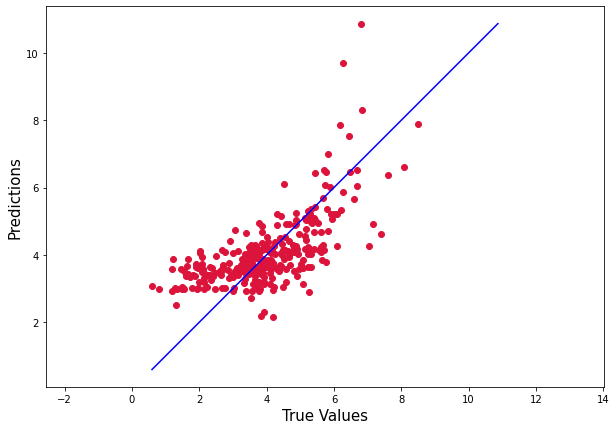

Pour le modèle : Régression_Ridge


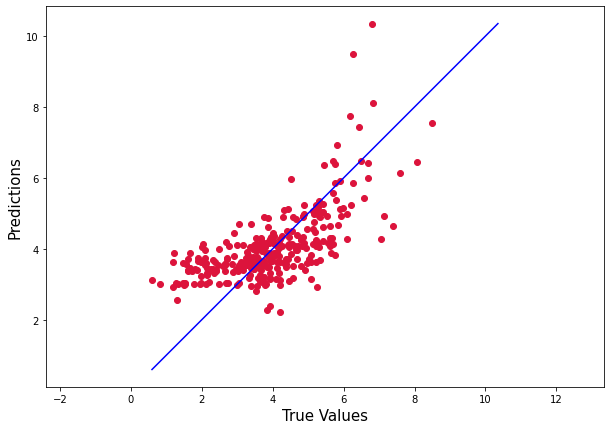

Pour le modèle : Régression_lasso


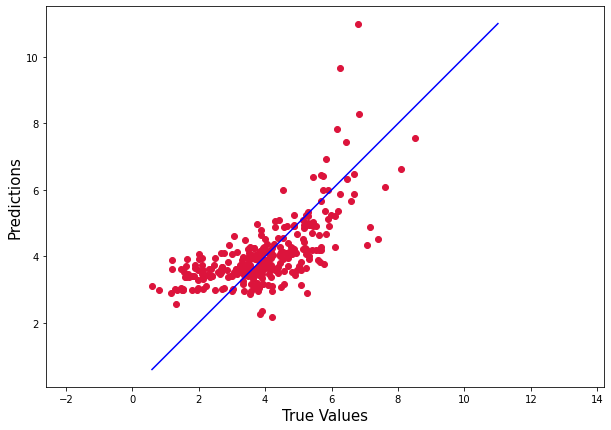

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.576e+02, tolerance: 1.852e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.881e+02, tolerance: 1.905e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.940e+02, tolerance: 1.950e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.316e+02, tolerance: 1.950e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.959e+02, tolerance: 1.898e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.969e+02, tolerance: 1.829e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.516e+02, tolerance: 1.852e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.760e+02, tolerance: 1.905e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.550e+02, tolerance: 1.898e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.615e+02, tolerance: 1.829e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.571e+02, tolerance: 1.852e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.873e+02, tolerance: 1.905e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.933e+02, tolerance: 1.950e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.171e+02, tolerance: 1.950e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.673e+02, tolerance: 1.898e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.631e+02, tolerance: 1.829e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.569e+02, tolerance: 1.852e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.869e+02, tolerance: 1.905e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.300e+02, tolerance: 1.829e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.739e+02, tolerance: 1.852e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.021e+02, tolerance: 1.905e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.100e+02, tolerance: 1.950e-01
Objective did not converge.

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.986e+02, tolerance: 1.905e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.065e+02, tolerance: 1.950e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.723e+02, tolerance: 1.898e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.754e+02, tolerance: 1.829e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.555e+02, tolerance: 1.852e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.950e+02, tolerance: 1.905e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.028e+02, tolerance: 1.950e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.693e+02, tolerance: 1.898e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.726e+02, tolerance: 1.829e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e+02, tolerance: 1.852e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.819e+02, tolerance: 1.905e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.995e+02, tolerance: 1.950e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.648e+02, tolerance: 1.898e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+02, tolerance: 1.852e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.878e+01, tolerance: 1.905e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.500e+01, tolerance: 1.950e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.654e+01, tolerance: 1.898e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.847e+01, tolerance: 1.829e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.239e+02, tolerance: 1.950e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.871e+02, tolerance: 1.898e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.935e+02, tolerance: 1.829e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.337e+01, tolerance: 1.852e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e+01, tolerance: 1.905e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.623e+02, tolerance: 1.950e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.351e+02, tolerance: 1.898e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.328e+02, tolerance: 1.829e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.057e+01, tolerance: 1.852e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e+01, tolerance: 1.905e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.443e+02, tolerance: 1.950e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.138e+02, tolerance: 1.898e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.897e+02, tolerance: 1.829e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+00, tolerance: 1.852e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e+00, tolerance: 1.905e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e+00, tolerance: 1.950e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.763e-01, tolerance: 1.829e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.011e+02, tolerance: 1.852e-01 Linear regressi

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.720e+02, tolerance: 1.950e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.461e+02, tolerance: 1.898e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.118e+02, tolerance: 1.829e-01 Linear regression models with null weig

Pour le modèle : Elastic_Net


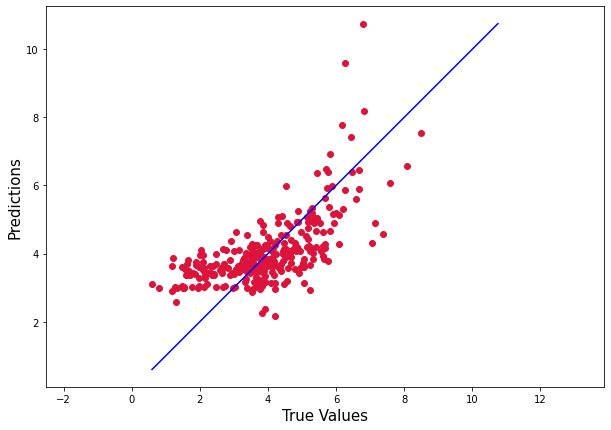

Pour le modèle : Support_Vecteur_Machine


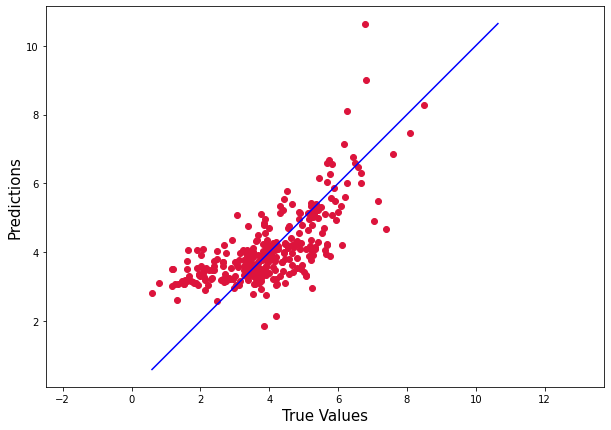

Pour le modèle : Kproches_voisins


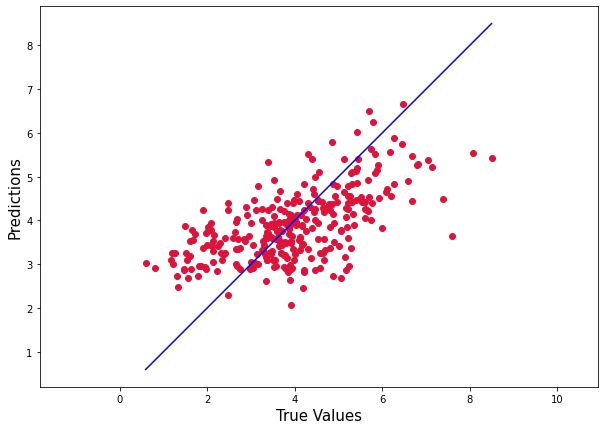

Pour le modèle : Arbre_de_décision


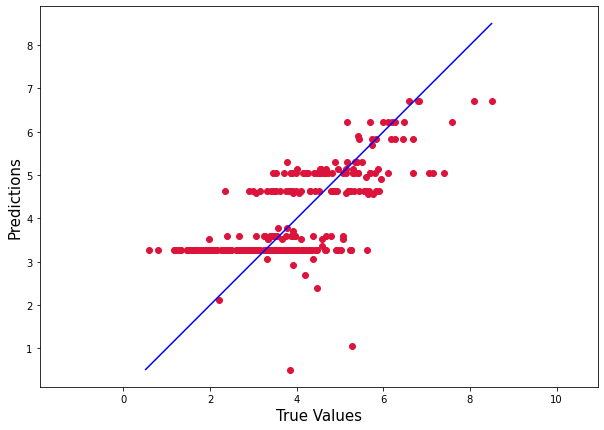


20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\salma\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\salma\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\salma\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\salma\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\salma\anaco

Pour le modèle : Foret_aléatoire


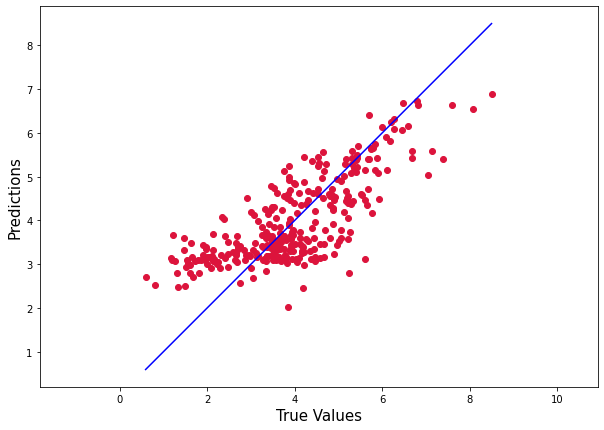

Pour le modèle : Gradient_Boosting


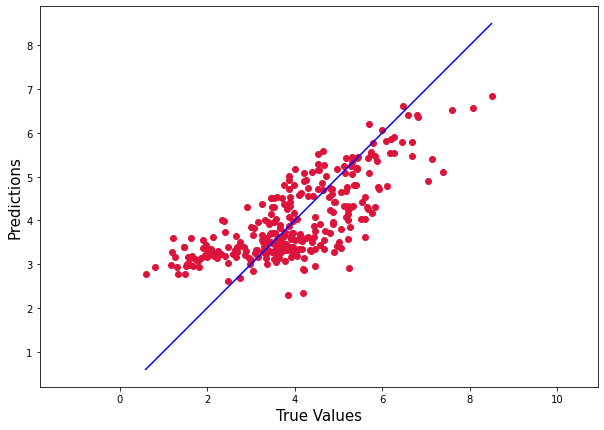

Pour le modèle : XgBoost


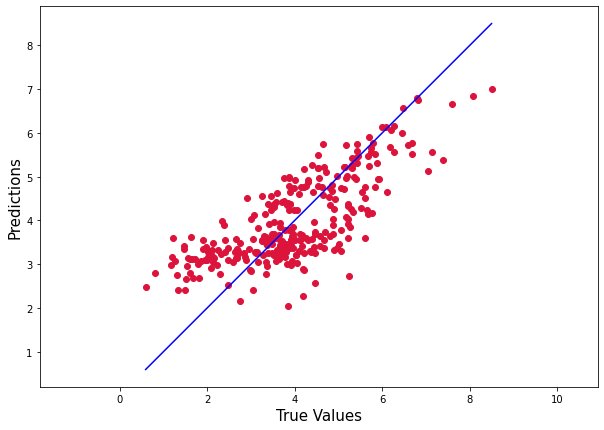

In [36]:
X_train,X_test,y_train,y_test = X_train, X_test,y_train,y_test = preprocessing_split(X_f,y_log, 0.2, strat=X_f['BuildingType'])
results_models = comparaison_models(name_models=name_models, models=list_models,x_train=X_train,x_test=X_test,y_train=y_train,y_test=y_test, params=list_params)

In [37]:
results_models

,Modele,best_paramètres,R2_train,R2_test,MSE_train,MSE_test,RMSE_train,RMSE_test,MAE_train,MAE_test,temps_exec
0,Régression_linéaire,{'fit_intercept': False},0.441784,0.429722,1.088294,1.090946,1.043213,1.044484,0.825402,0.809241,0.146583
1,Régression_Ridge,{'alpha': 1},0.440360,0.435934,1.091072,1.079063,1.044544,1.038780,0.829334,0.810634,1.250311
2,Régression_lasso,{'alpha': 0.001},0.439873,0.429321,1.092021,1.091713,1.044998,1.044851,0.827645,0.808848,0.302163
3,Elastic_Net,"{'alpha': 0.001, 'l1_ratio': 0.700000000000000...",0.440213,0.431992,1.091357,1.086604,1.044681,1.042403,0.828536,0.810114,18.206141
4,Support_Vecteur_Machine,"{'C': 70, 'gamma': 0.021544346900318822}",0.507846,0.489154,0.959501,0.977252,0.979541,0.988561,0.740554,0.760209,88.477689
5,Kproches_voisins,{'n_neighbors': 8},0.443431,0.377564,1.085084,1.190726,1.041674,1.091204,0.823884,0.863222,1.519985
6,Arbre_de_décision,{'max_depth': 6},0.529171,0.450584,0.917926,1.051038,0.958084,1.025201,0.743698,0.807272,0.302350
7,Foret_aléatoire,"{'max_depth': 10, 'min_samples_split': 3}",0.728977,0.576006,0.528386,0.811105,0.726901,0.900614,0.571063,0.720236,26.496046
8,Gradient_Boosting,"{'learning_rate': 0.04, 'max_depth': 4}",0.605397,0.552615,0.769315,0.855852,0.877106,0.925123,0.699136,0.745841,46.056363
9,XgBoost,"{'learning_rate': 0.05, 'max_depth': 5}",0.673277,0.570554,0.636978,0.821533,0.798109,0.906385,0.627047,0.734540,19.557218


### 4- L'utilité de la variable 'ENERGYSTARSCORE'

Il reste à tester sans ENERGYSTARScore

In [38]:
# On supprime les bâtiments qui n'ont pas d'énergyStarScore

df_ESS = df_eng.copy()
df_ESS = df_ESS.dropna(subset=['ENERGYSTARScore'])

col_with_ESS = ['BuildingType','Neighborhood','LargestPropertyUseType','LargestPropertyUseTypeGFA',
                'NumberofBuildings','NumberofFloors','Age','Ratio_Building','Ratio_Parking','SurfacePerFlor','ENERGYSTARScore']

target = 'TotalGHGEmissions'

X_ESS,y_ESS = separate(data=df_ESS, target=target, col=col_with_ESS)
y_ESS_log = y_ESS.apply(lambda x: np.log(1+x))
X_train,X_test,y_train,y_test = X_train, X_test,y_train,y_test = preprocessing_split(X_ESS,y_ESS_log, 0.2, strat=X_ESS['LargestPropertyUseType'])

In [39]:
X_train_sans_ESS = X_train.drop('ENERGYSTARScore', axis=1)
X_test_sans_ESS = X_test.drop('ENERGYSTARScore', axis=1)

Pour le modèle : Régression_linéaire


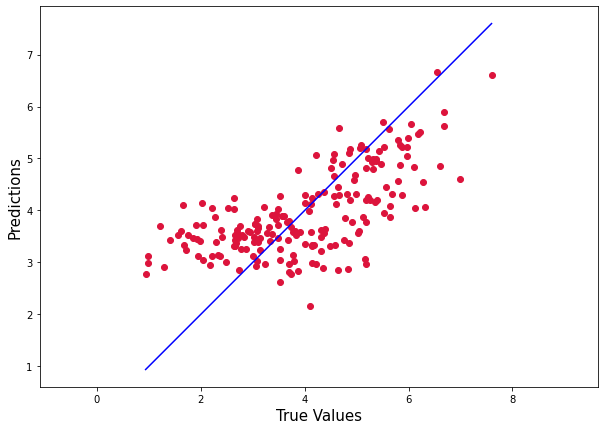

Pour le modèle : Régression_Ridge


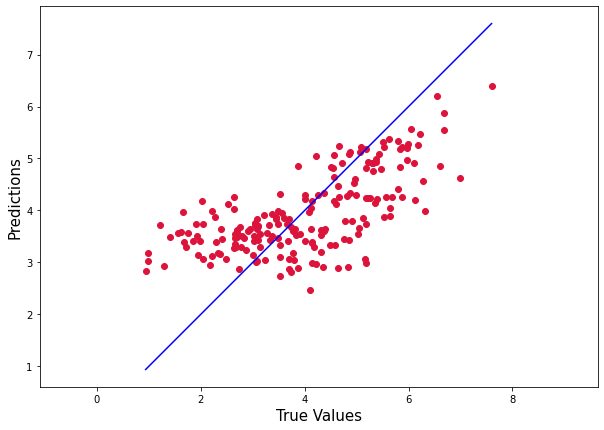

Pour le modèle : Régression_lasso


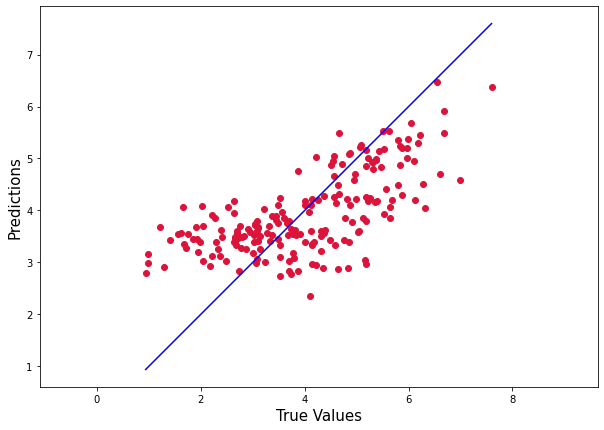

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.235e+02, tolerance: 1.216e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.017e+02, tolerance: 1.088e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e+02, tolerance: 1.180e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.591e+02, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.733e+02, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.232e+02, tolerance: 1.216e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.014e+02, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.186e+02, tolerance: 1.180e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.460e+02, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.658e+02, tolerance: 1.180e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.591e+02, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.729e+02, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e+02, tolerance: 1.216e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.272e+02, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.407e+02, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.338e+02, tolerance: 1.216e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+02, tolerance: 1.088e-01 Linear regression models wi

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e+02, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.420e+02, tolerance: 1.180e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.418e+02, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.454e+02, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.523e+01, tolerance: 1.216e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.197e+02, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.297e+02, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e+02, tolerance: 1.216e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.248e+01, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.181e+02, tolerance: 1.180e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.936e+02, tolerance: 1.178e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+02, tolerance: 1.216e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.345e+02, tolerance: 1.088e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.758e+00, tolerance: 1.180e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.538e+01, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.429e+00, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.675e+02, tolerance: 1.216e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.446e+02, tolerance: 1.088e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e+00, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.209e+00, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.366e+02, tolerance: 1.216e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.240e+02, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.418e+02, tolerance: 1.180e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.470e+02, tolerance: 1.088e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.814e+02, tolerance: 1.180e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.772e+02, tolerance: 1.166e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.455e+01, tolerance: 1.216e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.106e+00, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.217e+01, tolerance: 1.180e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+01, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.546e+00, tolerance: 1.178e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.053e+02, tolerance: 1.216e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.418e+02, tolerance: 1.088e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.873e+02, tolerance: 1.180e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.440e+02, tolerance: 1.088e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.898e+02, tolerance: 1.180e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.827e+02, tolerance: 1.166e-01 Linear regression models with null weig

Pour le modèle : Elastic_Net


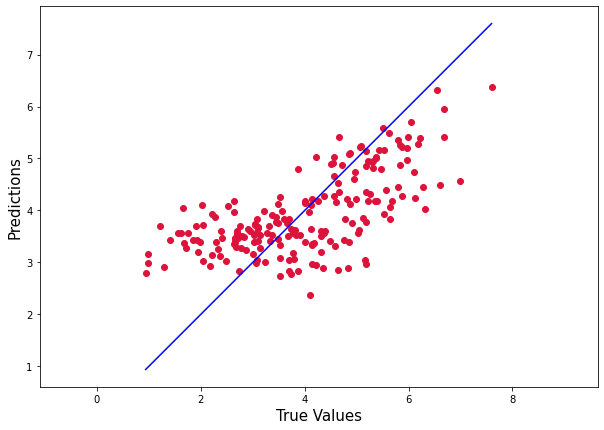

Pour le modèle : Support_Vecteur_Machine


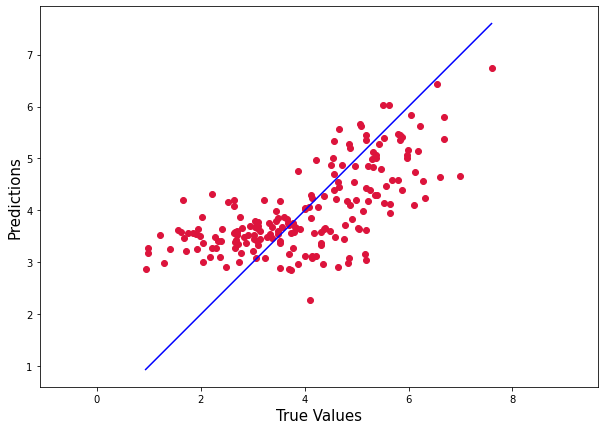

Pour le modèle : Kproches_voisins


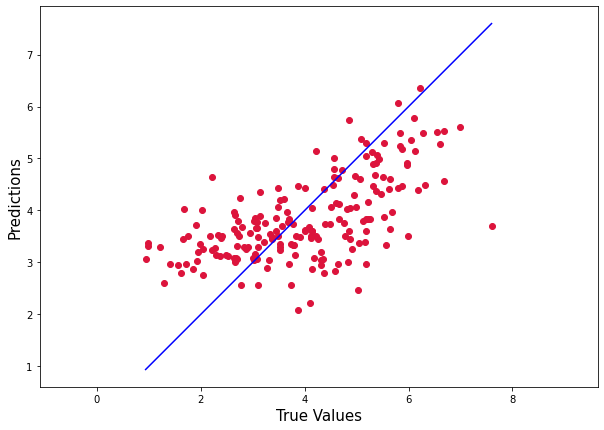

Pour le modèle : Arbre_de_décision


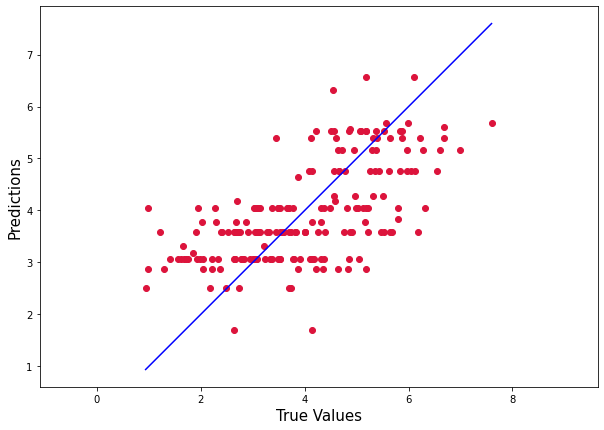


20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\salma\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\salma\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\salma\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\salma\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\salma\anaco

Pour le modèle : Foret_aléatoire


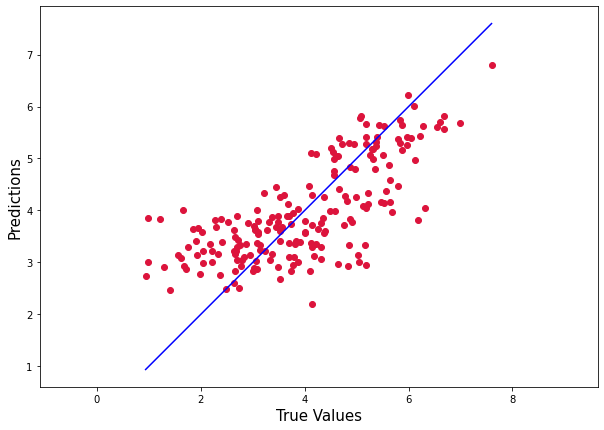

Pour le modèle : Gradient_Boosting


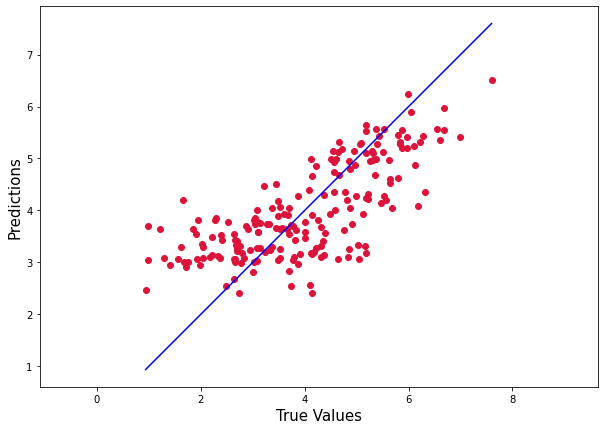

Pour le modèle : XgBoost


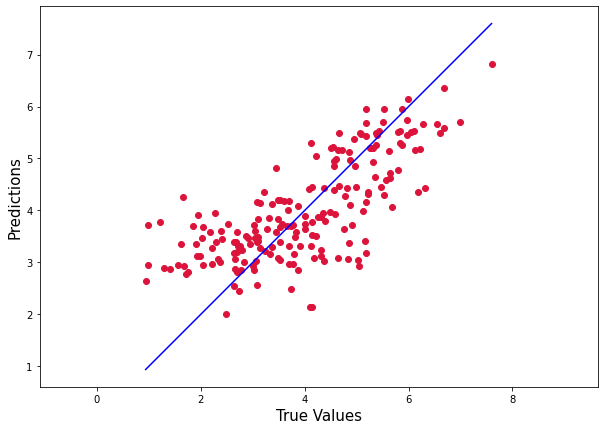

In [40]:
results_models_sans_ESS = comparaison_models(name_models=name_models, models=list_models,x_train=X_train_sans_ESS,x_test=X_test_sans_ESS,y_train=y_train,y_test=y_test, params=list_params)

In [41]:
results_models_sans_ESS

,Modele,best_paramètres,R2_train,R2_test,MSE_train,MSE_test,RMSE_train,RMSE_test,MAE_train,MAE_test,temps_exec
0,Régression_linéaire,{'fit_intercept': False},0.527037,0.439264,0.878534,1.085032,0.937302,1.041649,0.735386,0.849281,0.130579
1,Régression_Ridge,{'alpha': 1},0.522372,0.437517,0.887199,1.088413,0.941912,1.043270,0.741741,0.853325,0.807606
2,Régression_lasso,{'alpha': 0.001},0.525643,0.441349,0.881123,1.080999,0.938682,1.039711,0.736570,0.847655,0.253630
3,Elastic_Net,"{'alpha': 0.001, 'l1_ratio': 0.700000000000000...",0.524426,0.436098,0.883384,1.091158,0.939885,1.044585,0.737235,0.850058,12.923142
4,Support_Vecteur_Machine,"{'C': 60, 'gamma': 0.021544346900318822}",0.564432,0.450200,0.809071,1.063871,0.899484,1.031441,0.672141,0.835838,47.204312
5,Kproches_voisins,{'n_neighbors': 8},0.476709,0.367623,0.972019,1.223659,0.985910,1.106191,0.767634,0.896458,1.425246
6,Arbre_de_décision,{'max_depth': 6},0.642958,0.394007,0.663209,1.172605,0.814376,1.082869,0.608648,0.885016,0.270458
7,Foret_aléatoire,"{'max_depth': 10, 'min_samples_split': 2}",0.833104,0.529636,0.310010,0.910161,0.556786,0.954024,0.433145,0.762108,19.460450
8,Gradient_Boosting,"{'learning_rate': 0.04, 'max_depth': 4}",0.718669,0.533029,0.522576,0.903595,0.722894,0.950576,0.567869,0.765760,30.525066
9,XgBoost,"{'learning_rate': 0.07, 'max_depth': 5}",0.814963,0.543619,0.343708,0.883104,0.586266,0.939736,0.439950,0.748438,13.895399


Pour le modèle : Régression_linéaire


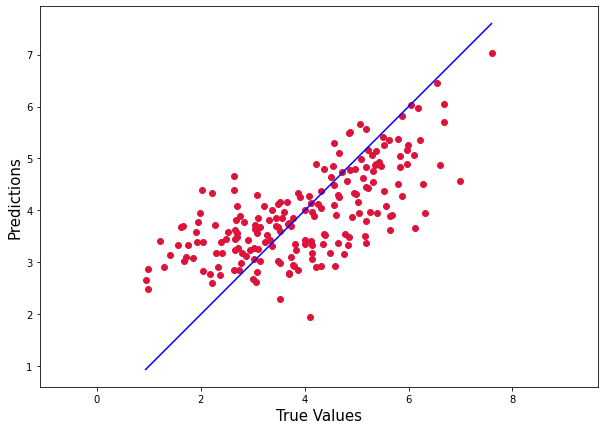

Pour le modèle : Régression_Ridge


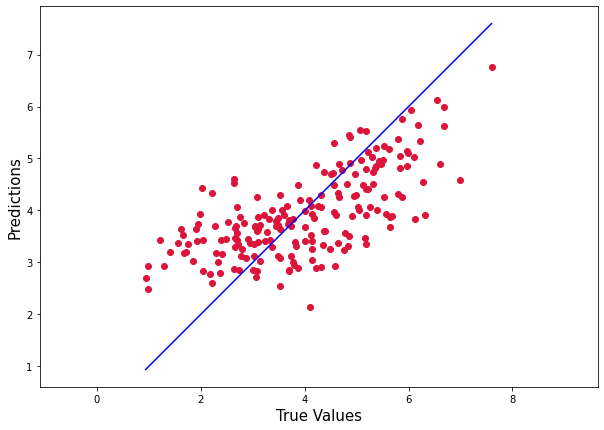

Pour le modèle : Régression_lasso


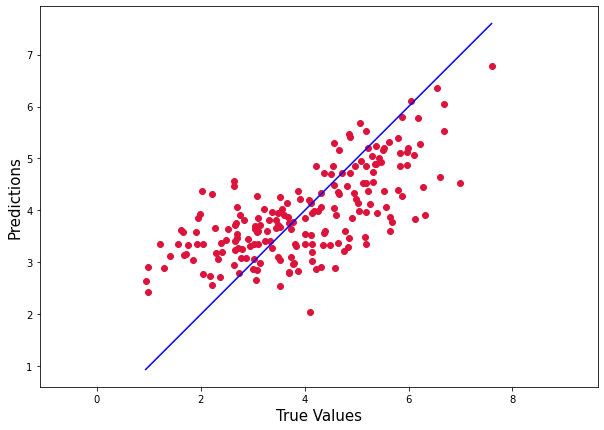

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.006e+02, tolerance: 1.216e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.809e+02, tolerance: 1.088e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e+02, tolerance: 1.180e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.559e+02, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.457e+02, tolerance: 1.216e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.256e+02, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.436e+02, tolerance: 1.180e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e+02, tolerance: 1.166e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.882e+02, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.982e+02, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.466e+02, tolerance: 1.216e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.261e+02, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.429e+02, tolerance: 1.180e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+02, tolerance: 1.216e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.909e+02, tolerance: 1.088e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e+02, tolerance: 1.180e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.296e+02, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.719e+01, tolerance: 1.216e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.571e+01, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.975e+01, tolerance: 1.180e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.116e+02, tolerance: 1.166e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e+02, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.182e+02, tolerance: 1.180e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e+02, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e+02, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e+01, tolerance: 1.216e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.734e+02, tolerance: 1.178e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.449e+02, tolerance: 1.216e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.197e+02, tolerance: 1.088e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.652e+00, tolerance: 1.180e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.938e+00, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.170e+00, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e+02, tolerance: 1.216e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.225e+02, tolerance: 1.088e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.928e-01, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.721e-01, tolerance: 1.180e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.328e-01, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e+00, tolerance: 1.178e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.043e+02, tolerance: 1.216e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.796e+02, tolerance: 1.178e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.848e+02, tolerance: 1.216e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.419e+02, tolerance: 1.088e-01 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.933e+00, tolerance: 1.216e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.519e+00, tolerance: 1.088e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.119e+00, tolerance: 1.180e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.903e+00, tolerance: 1.166e-01
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.549e+00, tolerance: 1.178e-01
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.079e+02, tolerance: 1.216e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.440e+02, tolerance: 1.088e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.898e+02, tolerance: 1.180e-01 Linear regression models with null weig

Pour le modèle : Elastic_Net


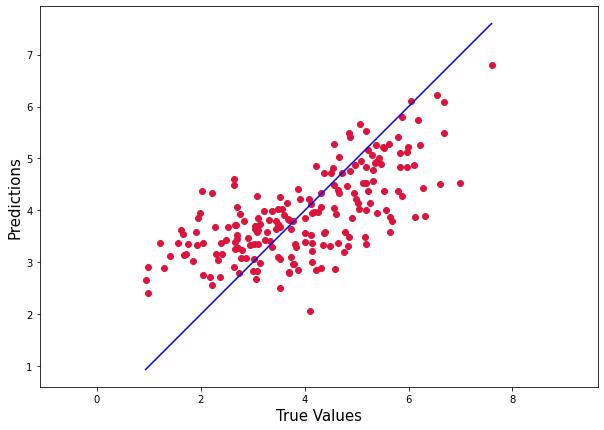

Pour le modèle : Support_Vecteur_Machine


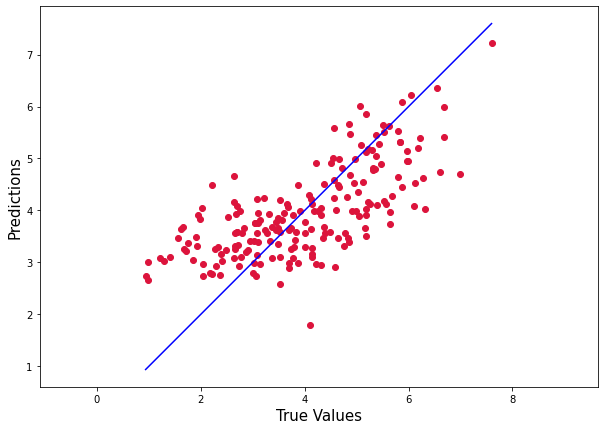

Pour le modèle : Kproches_voisins


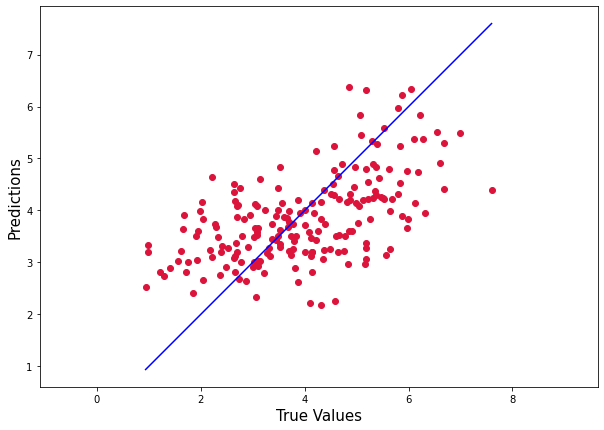

Pour le modèle : Arbre_de_décision


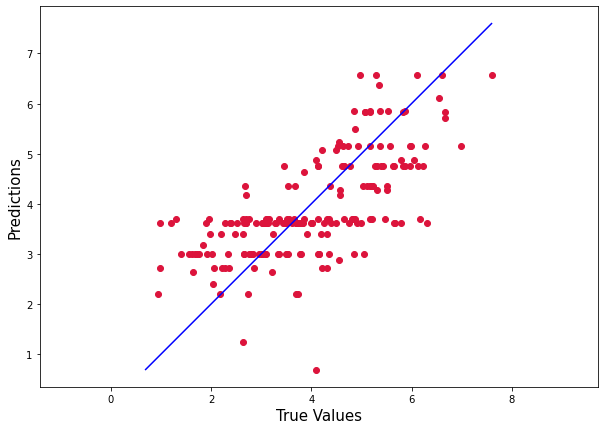


20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\salma\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\salma\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\salma\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\salma\anaconda3\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\salma\anaco

Pour le modèle : Foret_aléatoire


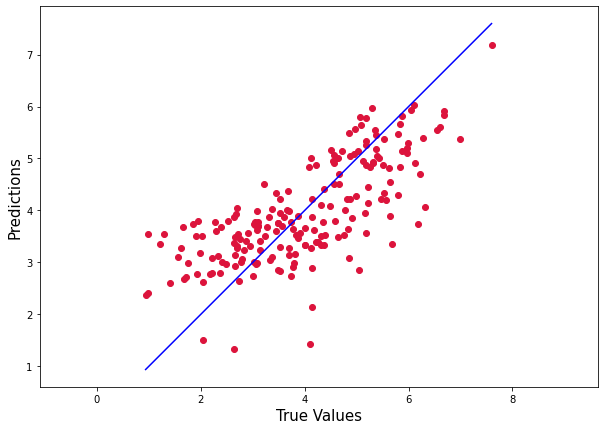

Pour le modèle : Gradient_Boosting


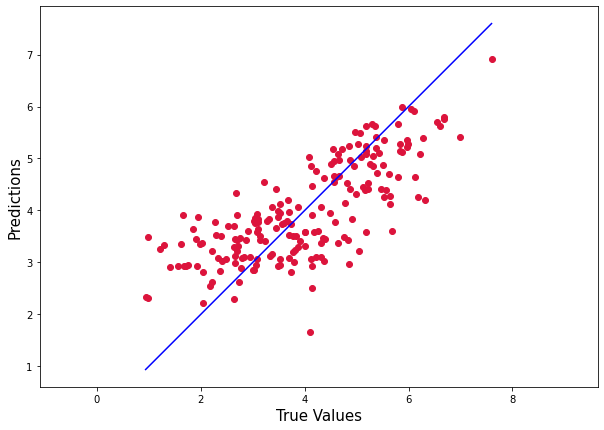

Pour le modèle : XgBoost


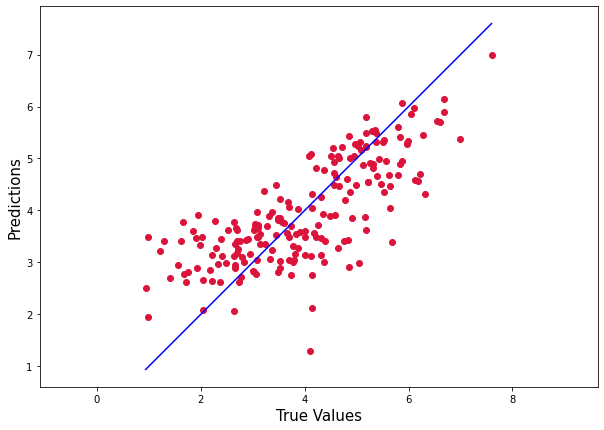

In [42]:
results_models_avec_ESS = comparaison_models(name_models=name_models, models=list_models,x_train=X_train,x_test=X_test,y_train=y_train,y_test=y_test, params=list_params)

In [43]:
results_models_avec_ESS

,Modele,best_paramètres,R2_train,R2_test,MSE_train,MSE_test,RMSE_train,RMSE_test,MAE_train,MAE_test,temps_exec
0,Régression_linéaire,{'fit_intercept': True},0.567035,0.464365,0.804237,1.036463,0.896793,1.018068,0.707463,0.819295,0.132720
1,Régression_Ridge,{'alpha': 1},0.563176,0.463124,0.811405,1.038863,0.900780,1.019246,0.713294,0.827084,0.781461
2,Régression_lasso,{'alpha': 0.001},0.566646,0.466354,0.804959,1.032614,0.897195,1.016176,0.706187,0.821148,0.292099
3,Elastic_Net,"{'alpha': 0.001, 'l1_ratio': 0.600000000000000...",0.565815,0.462439,0.806503,1.040190,0.898055,1.019897,0.707869,0.822927,10.181211
4,Support_Vecteur_Machine,"{'C': 70, 'gamma': 0.021544346900318822}",0.624264,0.487638,0.697933,0.991429,0.835424,0.995705,0.623423,0.801835,114.389943
5,Kproches_voisins,{'n_neighbors': 8},0.469885,0.313440,0.984694,1.328504,0.992317,1.152607,0.779274,0.930151,1.335933
6,Arbre_de_décision,{'max_depth': 6},0.669747,0.448575,0.613449,1.067016,0.783230,1.032965,0.598248,0.839515,0.249054
7,Foret_aléatoire,"{'max_depth': 10, 'min_samples_split': 3}",0.863719,0.538405,0.253144,0.893194,0.503134,0.945089,0.398994,0.762671,17.908746
8,Gradient_Boosting,"{'learning_rate': 0.04, 'max_depth': 4}",0.769275,0.568231,0.428574,0.835481,0.654656,0.914046,0.523346,0.738353,37.064308
9,XgBoost,"{'learning_rate': 0.05, 'max_depth': 5}",0.830000,0.579602,0.315777,0.813477,0.561940,0.901929,0.437929,0.715548,12.751120


On remarque que la variable 'ENERGYSTARScore' améliore les résultats des modèles

## E) Modèle final

Comme on peut le voir, les modèles ensemblistes ont de meilleurs scores par rapport aux modèles linéaires. On a que le modèle RandomForest a les meilleur performances. On choisit de l'utiliser comme modèle final.

### 1- Optimisation des paramètres

Comme on peut le voir, les modèles ensemblistes ont de meilleurs scores par rapport aux modèles linéaires. On a que le modèle Xgboost mets moins de temps d'exécutions par rapport au Gradient Boosting et au RandomForest. On choisit d'utiliser le XgBoost comme modèle final. On a comme meilleurs paramètres {'learning_rate': 0.05, 'max_depth': 5}.

### 1- Utilisation de Shap

In [44]:
shap.initjs()

In [45]:
model_f = XGBRegressor(max_depth=5, learning_rate=0.05) 

In [46]:
X_train,X_test,y_train,y_test = X_train, X_test,y_train,y_test = preprocessing_split(X_f,y_f, 0.2, strat=X_f['BuildingType'])

In [47]:
model_f.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


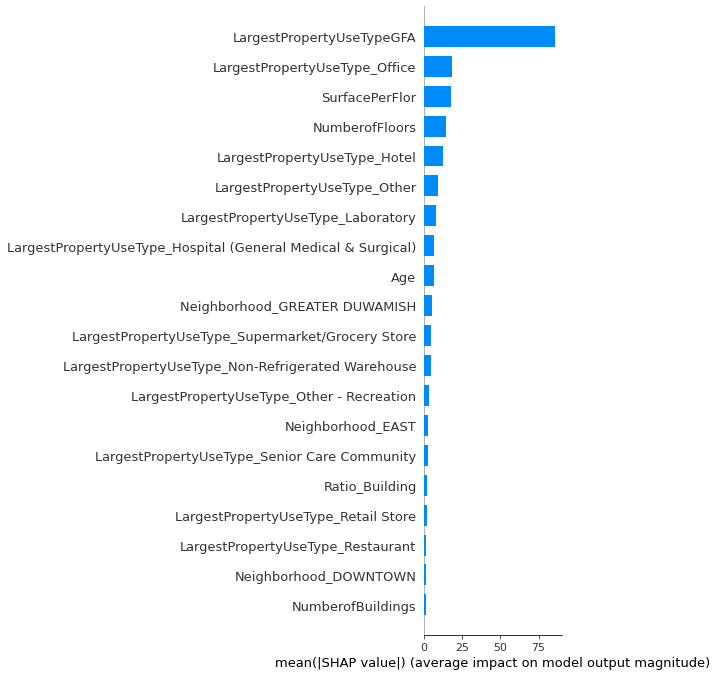

In [48]:
explainer = shap.TreeExplainer(model_f)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(7,7))
shap.summary_plot(shap_values, X_test, plot_type='bar')